# Clinical Trials Data Processing

## Goal

- To get a basic data processing pipeline outlined 
- To get the results we need to build a MVP 
- To understand future steps for more advanced study p

## TODOS
- Compare results filtering with the number of results from the GUI
- Parse all studies into workable CSVs with certain attributes 
- Create a safe method for getting values from the JSON file withought killin the study 
- Add in objective flags for measurement types
- Get the P-Values with the other types
- Add in the demographics to the csv
- Look at the missed values and see if the studies are really missing data 


In [1]:
# I think we just need to get all the studies and filter out the ones with results manually 
# We can make a module for this later
# The conditions can be easily parsed but we need to bucket them -> maybe make a model for that??
# The demographics are the easiest to get out of this
# Effectiveness - this can be done by averaging the difference between placebo and results, thought we 
# first have to filter the studies that have a placebo 
#
# Fields to be 

In [2]:
import requests
import pandas as pd
import scipy.stats as stats 
import nltk

API_BASE_URL='https://clinicaltrials.gov/api/query'
EXAMPLE_DRUG='gabapentin'

### Interfacing with ClinicalTrials.gov
- TODO: need to get all the studies not just the ones in a certain range 
- It's also worth noting that we can download all of this data

In [3]:
# First a basic API interface

def get_studies_by_expression(expression):
    r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk=1&max_rnk=99&fmt=json'
                     .format(expr=expression))
    return r.json()

def get_conditions_for_drug(drug):
    r = requests.get(API_BASE_URL + '/field_values?expr={drug}&field=ConditionAncestorTerm&fmt=json'
                     .format(drug=drug))
    
    return r.json()

In [4]:
def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies


## Conditions

### Consolidate the Conditions Data

- Need to get all the conditions in a formatted dataframe to parse the other results

- TODO: the AncestorConditions are too broad and the normal conditions are too specific -> we need our own 
method for this


In [5]:
raw_conditions_dict = get_conditions_for_drug('gabapentin') 

In [6]:
condition_field_values = raw_conditions_dict['FieldValuesResponse']['FieldValues']

In [7]:
parsable = {'Conditions': [], 'NStudies': []}
for value in condition_field_values:
    parsable['Conditions'].append(value['FieldValue'])
    parsable['NStudies'].append(value['NStudiesFoundWithValue'])

conditionsDf = pd.DataFrame.from_dict(parsable).sort_values('NStudies', ascending=False)
conditionsDf

,Conditions,NStudies
183,Neurologic Manifestations,200
176,Nervous System Diseases,173
198,Pain,155
203,Pathologic Processes,122
184,Neuromuscular Diseases,85
...,...,...
120,Infertility,1
121,"Infertility, Male",1
122,Inflammatory Bowel Diseases,1
123,Intellectual Disability,1


### Exploratory Statistics 
- Let's get a better feel for the conditions here 

In [8]:
conditionsDf.head(20)


,Conditions,NStudies
183,Neurologic Manifestations,200
176,Nervous System Diseases,173
198,Pain,155
203,Pathologic Processes,122
184,Neuromuscular Diseases,85
150,Mental Disorders,82
213,Postoperative Complications,68
207,Peripheral Nervous System Diseases,62
160,Musculoskeletal Diseases,44
246,Sleep Wake Disorders,40


<AxesSubplot:>

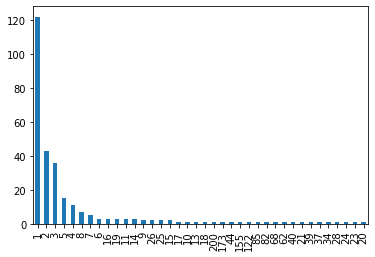

In [9]:
import matplotlib.pyplot as plt

conditionsDf['NStudies'].value_counts().plot.bar()

In [10]:
# We need to get a cutoff value for what conditions are going to be listed 
# The value should be percentage based to account for the differing study values for each drug
# Maybe the conditions that add up to 50% of the data or something 
# Actually let's just take top 5 - this is a problem for the medical people

conditionsDf.sum()['NStudies']

2189

In [11]:
count = 0
curr_sum = 0
total_sum = conditionsDf.sum()['NStudies']
for i in range(len(conditionsDf)):
    if curr_sum / total_sum > .1:
        break
    
    curr_sum += conditionsDf['NStudies'][i]
    count += 1


## Study Processing

- Filter out useless studies san results 
- Parse out useful values from the tree: place
- Create a dataframe for the other aspects of drug 

In [12]:
# Get all studies for all conditions for a given drug
# studies = []
# for condition in conditionsDf[0:3]['Conditions'].tolist():
#     print(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
#     studies += get_all_studies(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
    

### Parsing data
- Need to reduce the attrition rate for all the studies
- Let's get all the following into a csv -> a function for each

In [13]:
# Get all studies relating to Gabapentin 
studies = get_all_studies(EXAMPLE_DRUG)
len(studies)

112

### Create Tables
- Studies
- Groups
- Outcomes
- Measures

We need a good relational model to analyze this data fully

In [14]:
def create_studies_table(studies):
    buffer = {'id': [], 'name': [], 'drug': [], 'conditions': [], 
            'verified_date': [], 'responsible_party': [], 'type': [], 'description': []
         }
    for i, study in enumerate(studies):


        buffer['drug'].append(EXAMPLE_DRUG)
        try:
            buffer['id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
        except KeyError as e:
            buffer['id'].append('NA')

        try:
            buffer['name'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        except KeyError as e:
            buffer['name'].append('NA')

        try:
            buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
        except KeryError as e:
            buffer['verified_date'].append('NA')

        try:
            buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty'])
        except KeyError as e:
            buffer['responsible_party'].append('NA')

        try: 
            buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
        except KeyError as e:
            buffer['conditions'].append('NA')

        try:
            buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo']['DesignInterventionModel'])
        except KeyError as e:
            buffer['type'].append('NA')
            
        try:
            buffer['description'].append(study['Study']['ProtocolSection']['DescriptionModule']['DetailedDescription'])
        except KeyError as e:
            buffer['description'].append('NA')
    
    return buffer
studies_df = pd.DataFrame.from_dict(create_studies_table(studies))
studies_df.head()

,id,name,drug,conditions,verified_date,responsible_party,type,description
0,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...",gabapentin,"[Neurologically Impaired, Irritable Mood, Sign...",July 2019,{'ResponsiblePartyType': 'Sponsor'},Crossover Assignment,"This is a randomized, placebo-controlled, cros..."
1,NCT02359110,Administration of Pre-Operative Gabapentin to ...,gabapentin,[Postoperative Pain],March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,The purpose of this study is to prospectively ...
2,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,gabapentin,"[Pain, Postoperative]",May 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,Patients aged 10-19 years with idiopathic scol...
3,NCT02052414,"Open Labeled, Non-randomized, Study of Efficac...",gabapentin,[Fibromyalgia],September 2016,{'ResponsiblePartyType': 'Sponsor'},Single Group Assignment,Subject must carry a diagnosis of fibromyalgia...
4,NCT00578552,Gabapentin for Smoking Abstinence,gabapentin,"[Cigarette Smoking, Tobacco Use]",April 2011,"{'ResponsiblePartyOldNameTitle': 'Amit Sood, M...",Parallel Assignment,A total of 120 participants will be recruited ...


#### Groups Table
The control or placebo group that gets nothing 
- Name
- Study
- Id
- Number of participants 
- Description

In [15]:
def create_groups_table(studies): # The groups in the baseline -> this might end up badly 
    groups_df = { 
        'name': [],
        'study_id': [],
        'id': [],
        'description': [],
        'participants': []
    }
    parts = []
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        groups = []
        denoms = []
        try: 
            groups = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineGroupList']['BaselineGroup']
        except KeyError as e:
            groups = []
            
        for group in groups:

            groups_df['name'].append(group.get('BaselineGroupTitle', 'NA'))
            groups_df['study_id'].append(study_id)
            groups_df['id'].append(group.get('BaselineGroupId', 'NA'))
            groups_df['description'].append(group.get('BaselineGroupDescription'))
                
        try:
            denoms = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineDenomList']['BaselineDenom']
        except KeyError as e:
            denoms = []
            
        participants = list(filter(lambda x: x.get('BaselineDenomUnits', 'NA') == 'Participants', denoms))
        for participant in participants[0]['BaselineDenomCountList']['BaselineDenomCount']:
            groups_df['participants'].append(participant['BaselineDenomCountValue'])
    
    return groups_df, parts
        
groups = pd.DataFrame.from_dict(create_groups_table(studies)[0])
groups.head()

,name,study_id,id,description,participants
0,"Gabapentin, Then Placebo",NCT01675960,BG000,Participants first receive gabapentin 3 times ...,2
1,"Placebo, Then Gabapentin",NCT01675960,BG001,Participants first receive placebo 3 times per...,0
2,Total,NCT01675960,BG002,Total of all reporting groups,2
3,Gabapentin,NCT02359110,BG000,Patients will receive Gabapentin 300mg tab les...,55
4,Placebo,NCT02359110,BG001,Patients will receive Methylcellulose based pl...,54


#### Measures Table
- Study Id
- title
- Type 
- Description
- Disperision param
- Measure Param
- Units

In [16]:
def get_outcome_modules(studies):
    outcome_modules = []
    for study in studies:
        if 'OutcomeMeasuresModule' in study['Study']['ResultsSection']:
            outcome_modules.append(study['Study']['ResultsSection']['OutcomeMeasuresModule'])
            continue 
        print('No Results: ', study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        
    return outcome_modules

def create_measures_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'title': [],
        'type': [],
        'description': [],
        'dispersion_param': [],
        'measure_param': [],
        'units': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            df['type'].append(measure.get('OutcomeMeasureType', 'NA'))
            df['title'].append(measure.get('OutcomeMeasureTitle', 'NA'))
            df['description'].append(measure.get('OutcomeMeasureDescription', 'NA'))
            df['measure_param'].append(measure.get('OutcomeMeasureParamType', 'NA'))
            df['dispersion_param'].append(measure.get('OutcomeMeasureDispersionType', 'NA'))
            df['units'].append(measure.get('OutcomeMeasureUnitOfMeasure', 'NA'))
            df['study_id'].append(study_id)
            
    return df 

measures = pd.DataFrame.from_dict(create_measures_table(studies))
measures.head()

,study_id,title,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg


In [17]:
measures[measures['type'] == 'Primary']['units'].value_counts()

participants                      73
Participants                      52
units on a scale                  32
score on a scale                  11
Units on a scale                   8
                                  ..
mg/day x 5 days                    1
units on the VAS                   1
morphine milligram equivalents     1
morphine equivalents               1
percent change                     1
Name: units, Length: 77, dtype: int64

#### Outcomes Table
- Study_id
- Group_id
- Type
- Title
- Measure
- Unit
- Time
- Dispersion
- Upper 
- Lower
- Value 


In [18]:
def balance_df_dict(df_dict):
    goal_len = max([len(x) for x in df_dict.values()])
    for val in df_dict.values():
        while len(val) < goal_len:
            val.append('NA')
    
def create_outcomes_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'description': [],
        'type': [],
        'time': [],
        'dispersion': [],
        'upper': [],
        'lower': [],
        'value': [],
        'dose': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            try:
                for group in measure['OutcomeGroupList']['OutcomeGroup']:
                    df['study_id'].append(study_id)
                    df['group_id'].append(group.get('OutcomeGroupId', 'NA'))
                    df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                    df['title'].append(group.get('OutcomeGroupTitle', 'NA'))
                    df['description'].append(group.get('OutcomeGroupDescription', 'NA'))
                    df['type'].append('NA') # To be parsed later
                    df['dose'].append('NA') # To be parsed later
                
                for group in measure['OutcomeClassList']['OutcomeClass']:
                    df['time'].append(group['OutcomeClassTitle'])
                    
                    for cat in group['OutcomeCategoryList']['OutcomeCategory']:
                        for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
                            df['value'].append(outcome.get('OutcomeMeasurementValue', 'NA'))
                            df['dispersion'].append(outcome.get('OutcomeMeasurementSpread', 'NA'))
                            df['upper'].append(outcome.get('OutcomeMeasurementUpperLimit', 'NA'))
                            df['lower'].append(outcome.get('OutcomeMeasurementLowerLimit', 'NA'))
                            
                    
                    
            except KeyError as e:
                balance_df_dict(df)
                continue
                
    return df
        
outcomes = pd.DataFrame.from_dict(create_outcomes_table(studies))
outcomes.head()

,study_id,group_id,measure,title,description,type,time,dispersion,upper,lower,value,dose
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,NA,NA,NA,NA,NA,NA,NA
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...,NA,NA,NA,NA,NA,NA,NA
2,NCT01675960,OG000,Prevalence of Associated Gastrointestinal and ...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,NA,NA,NA,NA,NA,NA,NA
3,NCT01675960,OG001,Prevalence of Associated Gastrointestinal and ...,Placebo,Glycerin based clear solution that is flavored...,NA,NA,NA,NA,NA,NA,NA
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,NA,Hour 2,NA,4.5,2.6,3.5,NA


In [19]:
outcomes[outcomes['value'] != 'NA']

,study_id,group_id,measure,title,description,type,time,dispersion,upper,lower,value,dose
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,NA,Hour 2,NA,4.5,2.6,3.5,NA
5,NCT02359110,OG001,NRS (Numerical Rating Scale),Placebo,Patients will receive Methylcellulose based pl...,NA,Hour 4,NA,4.4,2.5,3.4,NA
6,NCT02359110,OG000,VAS (Visual Analog Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,NA,Hour 6,NA,6.5,4.3,5.4,NA
7,NCT02359110,OG001,VAS (Visual Analog Scale),Placebo,Patients will receive Methylcellulose based pl...,NA,Hour 8,NA,6.7,4.3,5.5,NA
8,NCT02359110,OG000,Total Morphine Consumption,Gabapentin,Patients will receive Gabapentin 300mg tab les...,NA,Hour 2,NA,6.5,4.2,5.3,NA
...,...,...,...,...,...,...,...,...,...,...,...,...
6331,NCT00667342,OG000,P95 of Ktrans by Good and Poor Response,All Participants,All 42 evaluable participants in this study ha...,NA,Good Response,0.0053,NA,NA,0.0491,NA
6332,NCT00667342,OG000,Difference Between Good and Poor Response by S...,All Participants,Thirty-two participants with osteosarcoma were...,NA,Poor Response,0.0224,NA,NA,0.2047,NA
6333,NCT00667342,OG000,Number of Participants With Neuropathic Pain (...,Amputation Group,Participants had metastatic disease at diagnosis.,NA,Good Response,0.0136,NA,NA,0.1228,NA
6334,NCT00667342,OG001,Number of Participants With Neuropathic Pain (...,Limb Sparing Group,Participants had localized disease at diagnosi...,NA,Poor Response,0.9303,NA,NA,6.2894,NA


In [23]:
# Now we actually need to add in the doses
# This is going to be tricky as the groups have sepperate doses
#Put it all together
units_map = {
    'milligram': 'mg',
    'kilogram': 'kg',
    'gram': 'g'
            }
def clean_doses_map(doses_map, hitlist):
    units = []
    nums_map = {}
    for num in doses_map:
        unit = []
        for word in doses_map[num]:
            if word in hitlist:
                unit.append(units_map[word] if word in units_map else word)
            elif '/' in word:
                unit.append('/'.join(filter(lambda x: x in hitlist, word.split('/'))))
        nums_map[num] = ''.join(unit).replace('per', '/')
    return nums_map

def check_trailings_for_measures(trailings, hitlist):
    mask = []
    for trailing in trailings:
        flag = False
        for word in trailing:
            if (word in hitlist) or ('/' in word):
                flag = True
        mask.append(flag)

    return mask

def get_nums_trailings(trailings, nums, hitlist):
    mask = check_trailings_for_measures(trailings, hitlist)
    return {nums[i]:trailings[i] for i in range(len(nums)) if mask[i]}
        
doses_hit_list = ['mg', 'g', 'kg', 'milligram', 'kilogram', 'gram', 'per']
doses_hit_list += [x+'/' for x in doses_hit_list]

stemmer = nltk.stem.PorterStemmer()
def apply_to_nested_list(nested_list, func):
    for i, lst in enumerate(nested_list):
        lst = [func(x) for x in lst]
        nested_list[i] = lst
    return nested_list

def get_numbers(string):
    nums= []
    curr_num= []
    for char in string:
        if char.isdigit():
            curr_num.append(char)
        elif curr_num:
            nums.append(int(''.join(curr_num)))
            curr_num = []
            
    return nums

def get_trailing_words(string, nums):
    trailings = []
    for num in nums:
        trailings.append([x.replace('.', '').replace('(','').replace(')','') for x in string.split(str(num))[1].split()[0:3]])
    return trailings

def get_doses(string): #Typically the string is the description
    nums = get_numbers(string)
    trailings = get_trailing_words(string, nums)
    stemmed = apply_to_nested_list(trailings, stemmer.stem)
    return clean_doses_map(get_nums_trailings(stemmed, nums, doses_hit_list), doses_hit_list)
    

outcomes['dose'] = outcomes['description'].apply(get_doses)
outcomes

,study_id,group_id,measure,title,description,type,time,dispersion,upper,lower,value,dose
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,NA,NA,NA,NA,NA,NA,{40: 'mg/kg'}
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...,NA,NA,NA,NA,NA,NA,{}
2,NCT01675960,OG000,Prevalence of Associated Gastrointestinal and ...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,NA,NA,NA,NA,NA,NA,{40: 'mg/kg'}
3,NCT01675960,OG001,Prevalence of Associated Gastrointestinal and ...,Placebo,Glycerin based clear solution that is flavored...,NA,NA,NA,NA,NA,NA,{}
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,NA,Hour 2,NA,4.5,2.6,3.5,{300: 'mg'}
...,...,...,...,...,...,...,...,...,...,...,...,...
6343,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...,NA,NA,NA,NA,NA,NA,{}
6344,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,Entire Study Group,Participants enrolled on the study who met the...,NA,NA,NA,NA,NA,NA,{}
6345,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,Amputation Group,Participants had metastatic disease at diagnosis.,NA,NA,NA,NA,NA,NA,{}
6346,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...,NA,NA,NA,NA,NA,NA,{}


In [15]:
# Get all the names used for groups
def parse_outcome_modules(outcomes):
    outcome_df = {'groups': [], 'outcome_measures': []}
    for outcome in outcomes:
        try: 
            outcome_df['outcome_measures'].append(outcome['OutcomeMeasureList']['OutcomeMeasure'])
        except KeyError as e:
            outcome_df['outcome_measures'].append('NA')
                  
        try: 
            outcome_df['groups'].append([x['OutcomeGroupList']['OutcomeGroup'] for x in outcome['OutcomeMeasureList']['OutcomeMeasure']])
        except KeyError as e:
            outcome_df['groups'].append('NA')
                  
    return outcome_df
            
outcomes = pd.DataFrame.from_dict(parse_outcome_modules(outcome_modules))
outcomes['name'] = pd.Series((study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'] for study in studies))
outcomes['study_type'] = pd.Series((study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignInterventionModel', 'NA') for study in studies))



In [16]:
outcomes['primary_measures'] = outcomes['outcome_measures'].apply(lambda x: [y for y in x if y['OutcomeMeasureType'] == 'Primary'])
outcomes['secondary_measures'] = outcomes['outcome_measures'].apply(lambda x: [y for y in x if y['OutcomeMeasureType'] == 'Secondary'])



In [17]:
outcomes['primary_groups'] = outcomes['primary_measures'].apply(lambda x: [y['OutcomeGroupList']['OutcomeGroup'] for y in x])
outcomes['secondary_groups'] = outcomes['secondary_measures'].apply(lambda x: [y['OutcomeGroupList']['OutcomeGroup'] for y in x])



A look at the number of outcome measurements and groups

The data is nested and very complex

,groups,outcome_measures,name,study_type,primary_measures,secondary_measures,primary_groups,secondary_groups,no_primary,no_secondary,no_other,no_total,no_groups
0,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","A Phase II, Randomized, Placebo-controlled, Do...",Crossover Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",1,1,0,2,2
1,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Administration of Pre-Operative Gabapentin to ...,Parallel Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",1,2,0,3,3
2,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Pain Control in Pediatric Posterior Spine Fusi...,Parallel Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",1,1,0,2,2
3,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","Open Labeled, Non-randomized, Study of Efficac...",Single Group Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",1,3,1,5,5
4,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Gabapentin for Smoking Abstinence,Parallel Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",[],"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",[],1,0,0,1,1


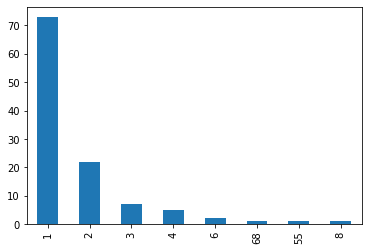

In [18]:

# There are way more measures than when I first thought - we need to add a priamry/secondary outcome tab
# and put them in a parsed format
outcomes['no_primary'] = outcomes['primary_measures'].apply(len)
outcomes['no_secondary'] = outcomes['secondary_measures'].apply(len)
outcomes['no_other'] = outcomes['outcome_measures'].apply(lambda x: len([y for y in x if y['OutcomeMeasureType'] == 'Other Pre-specified']))
outcomes['no_total'] = outcomes['outcome_measures'].apply(len)
outcomes['no_groups'] = outcomes['groups'].apply(len)


outcomes['no_primary'].value_counts(sort=True).plot.bar()
outcomes.head()


Getting out the primary, secondary, and other measures out in a good way is difficult
We need specific values in those groups
 - Placebo group id 
 - Drug group id 
 - Descriptions of the above 
 - Outcome param type 
 - Outcome range type
 - Dosage 
 
Essentially everything - we will continue focusing on the placebo group id.

We need to enumerate all the possible ways placebo groups are identified and account for them all

Unfortunately - we need to label the data to get our error rate for identifyign the placebo group

In [19]:
# Get all fields that have values that look like groups 

def get_group_titles(groups):
    titles = []
    for group in groups:
        for ind in group:
            if 'OutcomeGroupTitle' in ind:
                titles.append(ind['OutcomeGroupTitle'])
                continue
            print(ind)
            
    return titles

titles = outcomes['primary_groups'].apply(get_group_titles).tolist()
unique_titles = pd.Series([item for sublist in titles for item in sublist]).value_counts().index.tolist() # These need to be primary for sure


Let's get a good dataframe of the groups
Needs: 
- Title 
- Type
- GroupID
- Study name
- Study description 
- Results 
- Range
- Description
- Dose


In [20]:
def create_group_df(groups, study_title, study_type, measure_type):
    group_base = {'name': [], 'type': [], 'study_title': [], 'group_id': [], 'study_type': [], 'description':[]}
    for i in range(len(groups)):
        for nestedgroups2 in groups[i]:
            for group in nestedgroups2:
                try:
                    group_base['name'].append(group['OutcomeGroupTitle'])
                except KeyError as e:
                    group_base['name'].append('NA')

                try: 
                    group_base['group_id'].append(group['OutcomeGroupId'])
                except KeyError as e:
                    group_base['group_id'].append('NA')
                    
                try:
                    group_base['description'].append(group.get('OutcomeGroupDescription', '').lower())
                except KeyError as e:
                    group_base['description'].append('NA')

                group_base['type'].append(measure_type[i])
                group_base['study_title'].append(study_title[i])
                group_base['study_type'].append(study_type[i])
            
    return group_base

groups = outcomes['primary_groups'].tolist()
names = outcomes['name'].tolist()
types = outcomes['study_type'].tolist()
measure_types = ['primary' for x in range(len(names))]


groups = pd.DataFrame.from_dict(create_group_df(groups, names, types, measure_types))
groups.head()

,name,type,study_title,group_id,study_type,description
0,Gabapentin,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG000,Crossover Assignment,neurotin\n\ngabapentin: the active drug is in ...
1,Placebo,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG001,Crossover Assignment,glycerin based clear solution that is flavored...
2,Gabapentin,primary,Administration of Pre-Operative Gabapentin to ...,OG000,Parallel Assignment,patients will receive gabapentin 300mg tab les...
3,Placebo,primary,Administration of Pre-Operative Gabapentin to ...,OG001,Parallel Assignment,patients will receive methylcellulose based pl...
4,Gabapentin,primary,Pain Control in Pediatric Posterior Spine Fusi...,OG000,Parallel Assignment,gabapentin 15 milligrams per kilogram will be ...


In [21]:
# Add in some convenience features 

groups['has_placebo'] = groups['name'].apply(lambda x: 'placebo' in x.lower())
groups['has_drug'] = groups['name'].apply(lambda x: 'gabapentin' in x.lower())
groups.head()

,name,type,study_title,group_id,study_type,description,has_placebo,has_drug
0,Gabapentin,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG000,Crossover Assignment,neurotin\n\ngabapentin: the active drug is in ...,False,True
1,Placebo,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG001,Crossover Assignment,glycerin based clear solution that is flavored...,True,False
2,Gabapentin,primary,Administration of Pre-Operative Gabapentin to ...,OG000,Parallel Assignment,patients will receive gabapentin 300mg tab les...,False,True
3,Placebo,primary,Administration of Pre-Operative Gabapentin to ...,OG001,Parallel Assignment,patients will receive methylcellulose based pl...,True,False
4,Gabapentin,primary,Pain Control in Pediatric Posterior Spine Fusi...,OG000,Parallel Assignment,gabapentin 15 milligrams per kilogram will be ...,False,True


In [22]:
# Let's parse out list of numbers for each one of the descriptions
# we can also try and parse out measurements 
# I think we need to parse out measurements first then split the string 
# Looks to be a little more complicated we also need to consider the mg per kg measurements 


doses_hit_list = ['mg']
groups['description'].apply(lambda x: [int(y) for y in x.split() if y.isdigit()])


0      [22, 7, 6, 3]
1                 []
2                [1]
3                [1]
4           [15, 10]
           ...      
717              [3]
718              [3]
719               []
720               []
721               []
Name: description, Length: 722, dtype: object

In [23]:
# Find the numbers then take the next three words to get the possible dosing measurements
def get_numbers(string):
    nums= []
    curr_num= []
    for char in string:
        if char.isdigit():
            curr_num.append(char)
        elif curr_num:
            nums.append(int(''.join(curr_num)))
            curr_num = []
            
    return nums

def get_trailing_words(string, nums):
    trailings = []
    for num in nums:
        trailings.append([x.replace('.', '').replace('(','').replace(')','') for x in string.split(str(num))[1].split()[0:3]])
    return trailings
        

groups['nums'] = groups['description'].apply(get_numbers)
groups['trailings'] = groups.apply(lambda x: get_trailing_words(x.description, x.nums), axis=1)
groups.head()

,name,type,study_title,group_id,study_type,description,has_placebo,has_drug,nums,trailings
0,Gabapentin,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG000,Crossover Assignment,neurotin\n\ngabapentin: the active drug is in ...,False,True,"[22, 40, 7, 6, 3]","[[days, the, total], [mg/kg/day, once, 7], [da..."
1,Placebo,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG001,Crossover Assignment,glycerin based clear solution that is flavored...,True,False,[],[]
2,Gabapentin,primary,Administration of Pre-Operative Gabapentin to ...,OG000,Parallel Assignment,patients will receive gabapentin 300mg tab les...,False,True,"[300, 1]","[[mg, tab, less], [hour, before, surgery]]"
3,Placebo,primary,Administration of Pre-Operative Gabapentin to ...,OG001,Parallel Assignment,patients will receive methylcellulose based pl...,True,False,[1],"[[hour, before, surgery]]"
4,Gabapentin,primary,Pain Control in Pediatric Posterior Spine Fusi...,OG000,Parallel Assignment,gabapentin 15 milligrams per kilogram will be ...,False,True,"[15, 10]","[[milligrams, per, kilogram], [milligrams, per..."


In [24]:
# Need to stem the trailings to match the measurements 
# Also need to remove periods

stemmer = nltk.stem.PorterStemmer()
def apply_to_nested_list(nested_list, func):
    for i, lst in enumerate(nested_list):
        lst = [func(x) for x in lst]
        nested_list[i] = lst
    return nested_list

groups['trailings_stemmed'] = groups['trailings'].apply(lambda x: apply_to_nested_list(x, stemmer.stem))
groups.head()

,name,type,study_title,group_id,study_type,description,has_placebo,has_drug,nums,trailings,trailings_stemmed
0,Gabapentin,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG000,Crossover Assignment,neurotin\n\ngabapentin: the active drug is in ...,False,True,"[22, 40, 7, 6, 3]","[[day, the, total], [mg/kg/day, onc, 7], [day,...","[[day, the, total], [mg/kg/day, onc, 7], [day,..."
1,Placebo,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG001,Crossover Assignment,glycerin based clear solution that is flavored...,True,False,[],[],[]
2,Gabapentin,primary,Administration of Pre-Operative Gabapentin to ...,OG000,Parallel Assignment,patients will receive gabapentin 300mg tab les...,False,True,"[300, 1]","[[mg, tab, less], [hour, befor, surgeri]]","[[mg, tab, less], [hour, befor, surgeri]]"
3,Placebo,primary,Administration of Pre-Operative Gabapentin to ...,OG001,Parallel Assignment,patients will receive methylcellulose based pl...,True,False,[1],"[[hour, befor, surgeri]]","[[hour, befor, surgeri]]"
4,Gabapentin,primary,Pain Control in Pediatric Posterior Spine Fusi...,OG000,Parallel Assignment,gabapentin 15 milligrams per kilogram will be ...,False,True,"[15, 10]","[[milligram, per, kilogram], [milligram, per, ...","[[milligram, per, kilogram], [milligram, per, ..."


In [25]:
def flatten_triple_list(trip_list):
    for nest1 in trip_list:
        for nest2 in nest1:
            for item in nest2:
                yield item

# We need to enumerate these words to see what we need to put in our hitlist
trailings = pd.Series(flatten_triple_list(groups['trailings'].tolist())) #[item for sublist in t for item in sublist]
trailings.value_counts()

januari         1077
mg               763
to               554
day              495
20               471
                ... 
01                 1
750mg/dayx5;       1
eras,              1
dph                1
500                1
Length: 381, dtype: int64

In [26]:
#Try and get the nums with relevant trailings
def check_trailings_for_measures(trailings, hitlist):
    mask = []
    for trailing in trailings:
        flag = False
        for word in trailing:
            if (word in hitlist) or ('/' in word):
                flag = True
        mask.append(flag)

    return mask

def get_nums_trailings(trailings, nums, hitlist):
    mask = check_trailings_for_measures(trailings, hitlist)
    return {nums[i]:trailings[i] for i in range(len(nums)) if mask[i]}
        
        

doses_hit_list = ['mg', 'g', 'kg', 'milligram', 'kilogram', 'gram', 'per']
doses_hit_list += [x+'/' for x in doses_hit_list]

groups['doses_obj'] = groups.apply(lambda x: get_nums_trailings(x.trailings, x.nums, doses_hit_list), axis=1)
groups.head()

,name,type,study_title,group_id,study_type,description,has_placebo,has_drug,nums,trailings,trailings_stemmed,doses_obj
0,Gabapentin,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG000,Crossover Assignment,neurotin\n\ngabapentin: the active drug is in ...,False,True,"[22, 40, 7, 6, 3]","[[day, the, total], [mg/kg/day, onc, 7], [day,...","[[day, the, total], [mg/kg/day, onc, 7], [day,...","{40: ['mg/kg/day', 'onc', '7']}"
1,Placebo,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG001,Crossover Assignment,glycerin based clear solution that is flavored...,True,False,[],[],[],{}
2,Gabapentin,primary,Administration of Pre-Operative Gabapentin to ...,OG000,Parallel Assignment,patients will receive gabapentin 300mg tab les...,False,True,"[300, 1]","[[mg, tab, less], [hour, befor, surgeri]]","[[mg, tab, less], [hour, befor, surgeri]]","{300: ['mg', 'tab', 'less']}"
3,Placebo,primary,Administration of Pre-Operative Gabapentin to ...,OG001,Parallel Assignment,patients will receive methylcellulose based pl...,True,False,[1],"[[hour, befor, surgeri]]","[[hour, befor, surgeri]]",{}
4,Gabapentin,primary,Pain Control in Pediatric Posterior Spine Fusi...,OG000,Parallel Assignment,gabapentin 15 milligrams per kilogram will be ...,False,True,"[15, 10]","[[milligram, per, kilogram], [milligram, per, ...","[[milligram, per, kilogram], [milligram, per, ...","{15: ['milligram', 'per', 'kilogram'], 10: ['m..."


In [27]:
# Some manual checking 
groups['no_measure'] = pd.Series(['Unknown' for i in range(len(groups['has_drug']))])

In [28]:
groups[groups['has_drug'] & (groups['doses_obj'] == {})]['study_title']
groups.at[18, 'no_measure'] = 'True'
groups.at[63, 'no_measure'] = 'True'
groups.at[113, 'no_measure'] = 'True'
groups.at[240, 'no_measure'] = 'True'
groups.at[241, 'no_measure'] = 'True'
groups.at[242, 'no_measure'] = 'True'
groups.at[243, 'no_measure'] = 'True'
groups.at[244, 'no_measure'] = 'True'
groups.at[245, 'no_measure'] = 'True'
groups.at[246, 'no_measure'] = 'True'
groups.at[307, 'no_measure'] = 'True'
groups.at[317, 'no_measure'] = 'True'
groups.at[319, 'no_measure'] = 'True'
groups.at[320, 'no_measure'] = 'True'
groups.at[337, 'no_measure'] = 'True'
groups.at[365, 'no_measure'] = 'True'
groups.at[368, 'no_measure'] = 'True'
groups.at[375, 'no_measure'] = 'True'
groups.at[390, 'no_measure'] = 'True'
groups.at[451, 'no_measure'] = 'True'

In [29]:
#Put it all together
units_map = {
    'milligram': 'mg',
    'kilogram': 'kg',
    'gram': 'g'
            }
def clean_doses_map(doses_map, hitlist):
    units = []
    nums_map = {}
    for num in doses_map:
        unit = []
        for word in doses_map[num]:
            if word in hitlist:
                unit.append(units_map[word] if word in units_map else word)
            elif '/' in word:
                unit.append('/'.join(filter(lambda x: x in hitlist, word.split('/'))))
        nums_map[num] = ''.join(unit).replace('per', '/')
    return nums_map

groups['units'] = groups['doses_obj'].apply(lambda x: clean_doses_map(x, doses_hit_list))
groups

,name,type,study_title,group_id,study_type,description,has_placebo,has_drug,nums,trailings,trailings_stemmed,doses_obj,no_measure,units
0,Gabapentin,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG000,Crossover Assignment,neurotin\n\ngabapentin: the active drug is in ...,False,True,"[22, 40, 7, 6, 3]","[[day, the, total], [mg/kg/day, onc, 7], [day,...","[[day, the, total], [mg/kg/day, onc, 7], [day,...","{40: ['mg/kg/day', 'onc', '7']}",Unknown,{40: 'mg/kg'}
1,Placebo,primary,"A Phase II, Randomized, Placebo-controlled, Do...",OG001,Crossover Assignment,glycerin based clear solution that is flavored...,True,False,[],[],[],{},Unknown,{}
2,Gabapentin,primary,Administration of Pre-Operative Gabapentin to ...,OG000,Parallel Assignment,patients will receive gabapentin 300mg tab les...,False,True,"[300, 1]","[[mg, tab, less], [hour, befor, surgeri]]","[[mg, tab, less], [hour, befor, surgeri]]","{300: ['mg', 'tab', 'less']}",Unknown,{300: 'mg'}
3,Placebo,primary,Administration of Pre-Operative Gabapentin to ...,OG001,Parallel Assignment,patients will receive methylcellulose based pl...,True,False,[1],"[[hour, befor, surgeri]]","[[hour, befor, surgeri]]",{},Unknown,{}
4,Gabapentin,primary,Pain Control in Pediatric Posterior Spine Fusi...,OG000,Parallel Assignment,gabapentin 15 milligrams per kilogram will be ...,False,True,"[15, 10]","[[milligram, per, kilogram], [milligram, per, ...","[[milligram, per, kilogram], [milligram, per, ...","{15: ['milligram', 'per', 'kilogram'], 10: ['m...",Unknown,"{15: 'mg/kg', 10: 'mg/kg'}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,Pregabalin,primary,NEP-TUNE: Neuropathic Pain - Treatment With Pr...,OG000,NA,participants who were diagnosed with periphera...,False,False,[3],[[month]],[[month]],{},Unknown,{}
718,Pregabalin,primary,NEP-TUNE: Neuropathic Pain - Treatment With Pr...,OG000,NA,participants who were diagnosed with periphera...,False,False,[3],[[month]],[[month]],{},Unknown,{}
719,A: Localized Resectable Disease,primary,"A Study of Bevacizumab, a Humanized Monoclonal...",OG000,Parallel Assignment,stratum a participants had primary tumors pote...,False,False,[],[],[],{},Unknown,{}
720,C: Metastatic Tumors,primary,"A Study of Bevacizumab, a Humanized Monoclonal...",OG001,Parallel Assignment,stratum c participants had metastatic tumors.,False,False,[],[],[],{},Unknown,{}


In [30]:
# It looks like the title of the messures are the best bet right now - this has potential for being an nlp
# model 

In [31]:
pd.Series([x for y in groups['units'].tolist() for x in y]).value_counts()

600        88
1200       73
300        64
1800       46
2          32
1          29
3          25
100        22
900        22
200        18
5          17
4          16
50         15
10         13
20         12
400        12
6          10
2400       10
12          9
8           8
30          8
650         8
40          7
13512       7
25          7
2200        5
1838262     5
3600        5
975         4
150         4
75          4
1700        4
750         4
35          4
1100        4
15          3
7           2
1000        2
28          2
60          2
37          1
9           1
90          1
2220        1
250         1
450         1
1500        1
500         1
2700        1
800         1
0           1
dtype: int64

Still a very dirty way fo getting the units and not perfect, but this might be enough to run some 
basic analysis on the doses used

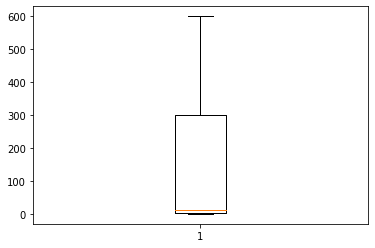

In [32]:
import matplotlib.pyplot as plt
drug_groups = groups[groups['has_drug']]
plt.boxplot([item for sublist in drug_groups['nums'] for item in sublist], showfliers=False)
plt.show()

In [33]:
# Write to csv for labeling

groups.to_csv('groups.csv')

Looks like we just want studies with paralell assignment, and then manually get the group with Gabapentin or other
brand names, then also get the placebo group by placebo, control,naive etc. 


#### Measures 
We need to create a measures table similar to groups
- Name of study

In [34]:
outcomes.head()

,groups,outcome_measures,name,study_type,primary_measures,secondary_measures,primary_groups,secondary_groups,no_primary,no_secondary,no_other,no_total,no_groups
0,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","A Phase II, Randomized, Placebo-controlled, Do...",Crossover Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",1,1,0,2,2
1,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Administration of Pre-Operative Gabapentin to ...,Parallel Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",1,2,0,3,3
2,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Pain Control in Pediatric Posterior Spine Fusi...,Parallel Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",1,1,0,2,2
3,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","Open Labeled, Non-randomized, Study of Efficac...",Single Group Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",1,3,1,5,5
4,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Gabapentin for Smoking Abstinence,Parallel Assignment,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",[],"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",[],1,0,0,1,1


In [35]:
def create_measure_row(study_name, study_type, measures):
    df = {'measure': [], 'study_name': [], 'study_type': [], 'measure_type': [], 
         'unit': [], 'timeframe': [], 'dispersion': [], 'denoms': [], 'title': []}
    for i in range(len(measures)):
        for measure in measures[i]:
            df['measure'].append(measure)
            df['measure_type'].append(measure.get('OutcomeMeasureParamType', 'NA'))
            df['unit'].append(measure.get('OutcomeMeasureUnitOfMeasure', 'NA'))
            df['timeframe'].append(measure.get('OutcomeMeasureTimeFrame', 'NA'))
            df['dispersion'].append(measure.get('OutcomeMeasureDispersionType', 'NA'))
            df['denoms'].append(measure.get('OutcomeDenomList', 'NA'))
            df['title'].append(measure.get('OutcomeMeasureTitle', 'NA'))
            df['study_name'].append(study_name[i])
            df['study_type'].append(study_type[i])
    
    return df

names = outcomes['name'].tolist()
types = outcomes['study_type'].tolist()
measures = outcomes['outcome_measures'].tolist()

measures = pd.DataFrame.from_dict(create_measure_row(names, types, measures))
measures.head()

,measure,study_name,study_type,measure_type,unit,timeframe,dispersion,denoms,title
0,"{'OutcomeMeasureType': 'Primary', 'OutcomeMeas...","A Phase II, Randomized, Placebo-controlled, Do...",Crossover Assignment,NA,NA,Compiled data reviewed at completion or withdr...,NA,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Symptom Relief for Chronic Irritability in Neu...
1,"{'OutcomeMeasureType': 'Secondary', 'OutcomeMe...","A Phase II, Randomized, Placebo-controlled, Do...",Crossover Assignment,NA,NA,Compiled data reviewed at completion or withdr...,NA,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Prevalence of Associated Gastrointestinal and ...
2,"{'OutcomeMeasureType': 'Primary', 'OutcomeMeas...",Administration of Pre-Operative Gabapentin to ...,Parallel Assignment,Least Squares Mean,units on a scale,2-8 hours,95% Confidence Interval,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,NRS (Numerical Rating Scale)
3,"{'OutcomeMeasureType': 'Secondary', 'OutcomeMe...",Administration of Pre-Operative Gabapentin to ...,Parallel Assignment,Least Squares Mean,units on a scale,2 -6 hours,95% Confidence Interval,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,VAS (Visual Analog Scale)
4,"{'OutcomeMeasureType': 'Secondary', 'OutcomeMe...",Administration of Pre-Operative Gabapentin to ...,Parallel Assignment,Mean,mg,12 hours post-operatively,Standard Deviation,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Total Morphine Consumption


<AxesSubplot:>

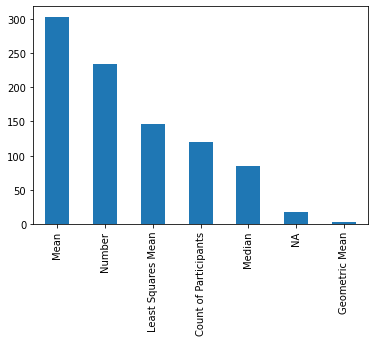

In [36]:
measures['measure_type'].value_counts().plot.bar()

<AxesSubplot:>

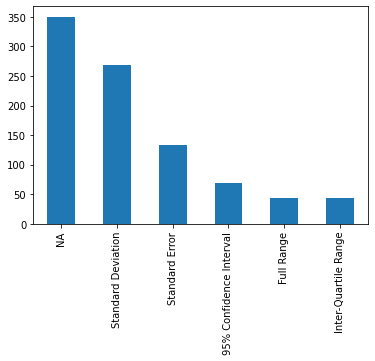

In [37]:
measures['dispersion'].value_counts().plot.bar()


In [38]:
def get_reverse_field(search_terms, search_space):
    def rec_helper(search_terms, search_space):
        if (isinstance(search_space, str)):
            return search_space in search_terms
        
        if (isinstance(search_space, list)):
            for item in search_space:
                isin = rec_helper(search_terms, item)
                if isin:
                    return isin
            return False
        
        for key in search_space:
            isin = rec_helper(search_terms, search_space[key])
            if isin:
                return key
        
        return False
    
    return rec_helper(search_terms, search_space)
        
    
    
measures[measures['dispersion'] == 'NA']['measure'].apply(
    lambda x: get_reverse_field(['Standard Deviation', '95% Confidence Interval', 'Standard Error', 'Full Range'], x)).value_counts()

# Okay so we have all the dispersions


False    350
Name: measure, dtype: int64

#### Score
We need to parse out the score from each measure - this looks like it is in the outcome class list

In [39]:
measures

,measure,study_name,study_type,measure_type,unit,timeframe,dispersion,denoms,title
0,"{'OutcomeMeasureType': 'Primary', 'OutcomeMeas...","A Phase II, Randomized, Placebo-controlled, Do...",Crossover Assignment,NA,NA,Compiled data reviewed at completion or withdr...,NA,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Symptom Relief for Chronic Irritability in Neu...
1,"{'OutcomeMeasureType': 'Secondary', 'OutcomeMe...","A Phase II, Randomized, Placebo-controlled, Do...",Crossover Assignment,NA,NA,Compiled data reviewed at completion or withdr...,NA,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Prevalence of Associated Gastrointestinal and ...
2,"{'OutcomeMeasureType': 'Primary', 'OutcomeMeas...",Administration of Pre-Operative Gabapentin to ...,Parallel Assignment,Least Squares Mean,units on a scale,2-8 hours,95% Confidence Interval,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,NRS (Numerical Rating Scale)
3,"{'OutcomeMeasureType': 'Secondary', 'OutcomeMe...",Administration of Pre-Operative Gabapentin to ...,Parallel Assignment,Least Squares Mean,units on a scale,2 -6 hours,95% Confidence Interval,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,VAS (Visual Analog Scale)
4,"{'OutcomeMeasureType': 'Secondary', 'OutcomeMe...",Administration of Pre-Operative Gabapentin to ...,Parallel Assignment,Mean,mg,12 hours post-operatively,Standard Deviation,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Total Morphine Consumption
...,...,...,...,...,...,...,...,...,...
904,"{'OutcomeMeasureType': 'Other Pre-specified', ...","A Study of Bevacizumab, a Humanized Monoclonal...",Parallel Assignment,Number,participants,Up to 6 months postoperatively,NA,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Number of Participants With Neuropathic Pain (...
905,"{'OutcomeMeasureType': 'Other Pre-specified', ...","A Study of Bevacizumab, a Humanized Monoclonal...",Parallel Assignment,Median,Weeks,"From surgery until resolution of NP symptoms, ...",Full Range,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Median Duration of Neuropathic Pain
906,"{'OutcomeMeasureType': 'Other Pre-specified', ...","A Study of Bevacizumab, a Humanized Monoclonal...",Parallel Assignment,Mean,Weeks,"From surgery until resolution of NP symptoms, ...",Standard Deviation,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Mean Duration of Neuropathic Pain
907,"{'OutcomeMeasureType': 'Other Pre-specified', ...","A Study of Bevacizumab, a Humanized Monoclonal...",Parallel Assignment,Median,Weeks,"From surgery until resolution of NP symptoms, ...",Full Range,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,Median Duration of Neuropathic Pain Medication


In [40]:
# Let's get out the class list 
def get_class_list(outcome_measure):
    try:
        return outcome_measure['OutcomeClassList']['OutcomeClass']
    
    except KeyError as e:
        return 'NA'

measures['outcome_class'] = measures['measure'].apply(lambda x: get_class_list(x))

<AxesSubplot:>

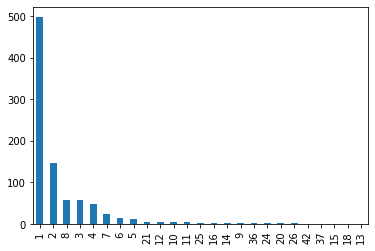

In [41]:
pd.Series(measures['outcome_class'].apply(len)).value_counts().plot.bar()

In [42]:
print(measures[measures['outcome_class'].apply(len) == 2]['study_name'][0:20])

# It looks like there can be multiple measurements taken for a primary meaure, say over the course of time

0      A Phase II, Randomized, Placebo-controlled, Do...
1      A Phase II, Randomized, Placebo-controlled, Do...
3      Administration of Pre-Operative Gabapentin to ...
16     Pilot Study to Assess Tolerability and Prelimi...
17     Pilot Study to Assess Tolerability and Prelimi...
18     Pilot Study to Assess Tolerability and Prelimi...
19     Pilot Study to Assess Tolerability and Prelimi...
20     Pilot Study to Assess Tolerability and Prelimi...
21     Pilot Study to Assess Tolerability and Prelimi...
30           Gabapentin Treatment of Cannabis Dependence
40     Randomized, Open-Label Quality of Life Study U...
41     Randomized, Open-Label Quality of Life Study U...
42     Randomized, Open-Label Quality of Life Study U...
43     Randomized, Open-Label Quality of Life Study U...
96     Gabapentin as an Adjunct to Perioperative Pain...
97     Gabapentin as an Adjunct to Perioperative Pain...
98     Gabapentin as an Adjunct to Perioperative Pain...
99     Gabapentin as an Adjunct

We need to get the scores from measure and match them up by group 

Or go through the groups and get the score from the measures table, or merge the tables

In [44]:
# A score needs to have group, title, outcome, and dispersion
# How do you analyze the different classes - we know it's the same group and measure, so it must be time?/
# Or maybe dose??
# Let's take a look

# I think we need to treat them seperately 
print(measures['outcome_class'][30])

[{'OutcomeClassTitle': '% Negative UDS ITT', 'OutcomeClassDenomList': {'OutcomeClassDenom': [{'OutcomeClassDenomUnits': 'Participants', 'OutcomeClassDenomCountList': {'OutcomeClassDenomCount': [{'OutcomeClassDenomCountGroupId': 'OG000', 'OutcomeClassDenomCountValue': '75'}, {'OutcomeClassDenomCountGroupId': 'OG001', 'OutcomeClassDenomCountValue': '75'}]}}]}, 'OutcomeCategoryList': {'OutcomeCategory': [{'OutcomeMeasurementList': {'OutcomeMeasurement': [{'OutcomeMeasurementGroupId': 'OG000', 'OutcomeMeasurementValue': '11.22', 'OutcomeMeasurementSpread': '21.77'}, {'OutcomeMeasurementGroupId': 'OG001', 'OutcomeMeasurementValue': '8.00', 'OutcomeMeasurementSpread': '19.83'}]}}]}}, {'OutcomeClassTitle': '% Negative UDS Observed', 'OutcomeClassDenomList': {'OutcomeClassDenom': [{'OutcomeClassDenomUnits': 'Participants', 'OutcomeClassDenomCountList': {'OutcomeClassDenomCount': [{'OutcomeClassDenomCountGroupId': 'OG000', 'OutcomeClassDenomCountValue': '73'}, {'OutcomeClassDenomCountGroupId': 

In [ ]:
def create_groups_table(studies)

In [20]:
counts = {}
for i, unique in enumerate(unique_titles):
    if i not in counts:
        counts[i] = [unique, s0]
    for group in titles:
        if unique in group:
            counts[i][1] += 1
    

counts = pd.DataFrame.from_dict(counts, orient='index')
counts

,0,1
0,Methotrexate (MTX) + Tofacitinib: MTX Persistent,1
1,Methotrexate (MTX) + Tofacitinib: MTX Disconti...,1
2,Methotrexate (MTX) + Tofacitinib: MTX Interrupted,1
3,Gabapentin,42
4,Placebo,37
...,...,...
183,Non-Opioid Intervention,1
184,Group 2: Gabapentin,1
185,G-ER,1
186,Non Stratified (Both +EIASD and -EIASD),1


In [21]:
counts[counts[0].str.lower().str.contains('placebo')]

,0,1
4,Placebo,37
39,Placebo Oral Capsule,3
44,Placebo/Morphine,1
46,Active Placebo,1
47,GEn Placebo,1
62,"Amitriptyline 4% Ketamine 2% Cream, Placebo Ca...",1
65,Placebo Cream and Capsules,1
68,GSK1838262 Placebo Match,1
69,3 Preoperative and Postoperative Placebo Liquid,1
75,"Gabapentin Capsules, Placebo Cream",1


In [15]:
def append_buffer_to_dfdict(buffer, df_dict):
    for k, v in buffer.items():
        df_dict[k]+=v
    

In [16]:
# Let's get this study into a big dataframe 
# TODO: we need catches for if these all error out 
# I think the plan is to create a buffer dict and if that dict completes add it 

df_dict = {'id': [], 'name': [], 'outcome_groups':[], 'drug': [], 'conditions': [], 
           'primary_outcomes': [], 'verified_date': [], 'responsible_party': [], 'type': [], 
           'type_description': [], 'outcome_measure':  [], 'outcome_spread': [], 
           'outcome_measure_param': [], 'outcomes': [], 'outcome_subjects': []
          }

for i, study in enumerate(studies):
    buffer = {'id': [], 'name': [], 'outcome_groups':[], 'drug': [], 'conditions': [], 
              'primary_outcomes': [], 'verified_date': [], 'responsible_party': [], 'type': [], 
              'type_description': [], 'outcome_measure':  [], 'outcome_spread': [], 
              'outcome_measure_param': [], 'outcomes': [], 'outcome_subjects': []
             }
    
    
    buffer['drug'].append(EXAMPLE_DRUG)
    try:
        buffer['id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
    except KeyError as e:
        buffer['id'].append('NA')
    
    try:
        buffer['name'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
    except KeyError as e:
        buffer['name'].append('NA')
        
    try:
        buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
    except KeryError as e:
        buffer['verified_date'].append('NA')
        
    try:
        buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty'])
    except KeyError as e:
        buffer['responsible_party'].append('NA')
        
    try: 
        buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
    except KeyError as e:
        buffer['conditions'].append('NA')
        
    try:
        buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo']['DesignInterventionModel'])
    except KeyError as e:
        buffer['type'].append('NA')
        
    try:
        buffer['type_description'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignInterventionModelDescription', ''))
    except KeyError as e:
        buffer['type_description'].append('NA')
        
    try:
        buffer['primary_outcomes'].append(study['Study']['ProtocolSection']['OutcomesModule']['PrimaryOutcomeList']['PrimaryOutcome'])
    except KeyError as e:
        buffer['primary_outcomes'].append('NA')
        
    try:
        buffer['outcome_groups'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0]['OutcomeGroupList']['OutcomeGroup'])
    except KeyError as e:
        buffer['outcome_groups'].append('NA')
        
    try:
        buffer['outcome_measure'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0]['OutcomeMeasureTitle'])
    except KeyError as e:
        buffer['outcome_measure'].append('NA')
        
    try:
        buffer['outcome_spread'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0].get('OutcomeMeasureDispersionType', ''))
    except KeyError as e:
        buffer['outcome_spread'].append('NA')
        
    try:
        buffer['outcome_measure_param'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0].get('OutcomeMeasureParamType', ''))
    except KeyError as e:
        buffer['outcome_measure_param'].append('NA')
        
    try:
        buffer['outcomes'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0].get('OutcomeClassList', ''))
    except KeyError as e:
        buffer['outcomes'].append('NA')
    
    try:
        buffer['outcome_subjects'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0].get('OutcomeDenomList', ''))
    except KeyError as e:
        buffer['outcomes'].append('NA')

    
    append_buffer_to_dfdict(buffer, df_dict)
    
    
studiesdf = pd.DataFrame.from_dict(df_dict)  
studiesdf

,id,name,outcome_groups,drug,conditions,primary_outcomes,verified_date,responsible_party,type,type_description,outcome_measure,outcome_spread,outcome_measure_param,outcomes,outcome_subjects
0,NCT02926573,Perioperative Gabapentin Use In Head And Neck ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Head and Neck Cancer, Acute Pain, Postoperati...",[{'PrimaryOutcomeMeasure': 'Change in Daily Na...,July 2018,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,Change in Daily Narcotic Consumption,Full Range,Median,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
1,NCT00414466,"A Randomized Double Blind, Placebo-controlled,...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Intractable Pain],[{'PrimaryOutcomeMeasure': 'Changes in a Pain ...,August 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,Changes in a Pain Rating Scale After 3 Weeks o...,Standard Deviation,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
2,NCT00108550,Efficacy of Antidepressants in Chronic Back Pain,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Low Back Pain],[{'PrimaryOutcomeMeasure': 'Transformed Descri...,December 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,Transformed Descriptor Differential Scale-Pain...,95% Confidence Interval,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
3,NCT02359110,Administration of Pre-Operative Gabapentin to ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'NRS (Numerical Rat...,March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,NRS (Numerical Rating Scale),95% Confidence Interval,Least Squares Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'Hour ...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
4,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Pain, Postoperative]",[{'PrimaryOutcomeMeasure': 'Difference in Pain...,May 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,Difference in Pain Control When Adding Gabapen...,Standard Deviation,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,NCT02605187,Patient-Driven Analgesic Protocol Selection fo...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'Opioid Consumption...,September 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,Opioid Consumption in the 0-48 Hour Study Peri...,Inter-Quartile Range,Median,{'OutcomeClass': [{'OutcomeClassTitle': '0-24 ...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
118,NCT01743976,Donepezil Compared to Placebo in Patients With...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Neuropathic Pain],[{'PrimaryOutcomeMeasure': 'McGill Short Form ...,October 2020,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,McGill Short Form Pain Questionnaire (SF MPQ) ...,Full Range,Median,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
119,NCT00386243,Evaluation of Stepped Care for Chronic Pain in...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Low Back Pain, Pain, Pain, Intractable]",[{'PrimaryOutcomeMeasure': 'Roland-Morris Disa...,May 2019,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,Roland-Morris Disability Questionnaire,Standard Deviation,Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'basel...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
120,NCT00243152,Evaluation of Lamotrigine on Neuropathic Facia...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Facial N

## Effectiveness


In [17]:
import json
# We need to get the outcomes in their own dataframe as well 
# Then we can compare everything to try and get a good outcome measurement
# first we need to get the placebo, range, and score out -> there are multiple though??
# The best way might be to just average all of them? We still need the group IDs for placebo and drug

studiesdf['outcomes'][2]

{'OutcomeClass': [{'OutcomeCategoryList': {'OutcomeCategory': [{'OutcomeMeasurementList': {'OutcomeMeasurement': [{'OutcomeMeasurementGroupId': 'OG000',
         'OutcomeMeasurementValue': '0.6683',
         'OutcomeMeasurementLowerLimit': '0.6145',
         'OutcomeMeasurementUpperLimit': '0.7220'},
        {'OutcomeMeasurementGroupId': 'OG001',
         'OutcomeMeasurementValue': '0.6988',
         'OutcomeMeasurementLowerLimit': '0.6463',
         'OutcomeMeasurementUpperLimit': '0.7512'}]}}]}}]}

In [44]:
# Here we add the placebo group as a column in the dataframe
def get_placebo_group(outcome_group):
    temp = list(filter(lambda x: 'placebo' in x['OutcomeGroupTitle'].lower() or 'control' in x['OutcomeGroupTitle'].lower(), outcome_group))
    if (temp):
        return temp[0]['OutcomeGroupId']
    
    return 'NA'

studiesdf['placebo_group'] = studiesdf['outcome_groups'].apply(get_placebo_group)

In [45]:
len(studiesdf[studiesdf['placebo_group'] == 'NA'])

46

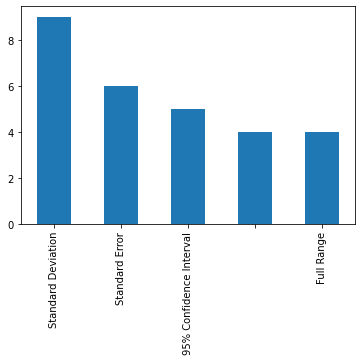

In [46]:
# Let's get an idea of the ranges here
bar = placebo_studies['outcome_spread'].value_counts().plot.bar()


In [47]:
import json

placebo_studies = studiesdf[studiesdf['placebo_group'] != 'NA']
# Get the results from the placebo group
# TODO: we really need to get the number of people for each group
def get_placebo_scores(outcomes, placebo_group):
    placebo_scores = []
    if 'OutcomeClass' in outcomes:
        for outcome_group in outcomes['OutcomeClass']:
            for measurement in outcome_group['OutcomeCategoryList']['OutcomeCategory'][0]['OutcomeMeasurementList']['OutcomeMeasurement']:
                if placebo_group == measurement['OutcomeMeasurementGroupId']: 
                    placebo_scores.append(measurement['OutcomeMeasurementValue'])
    
    return placebo_scores

def get_control_scores(outcomes, placebo_group):
    control_scores = []
    if 'OutcomeClass' in outcomes:
        for outcome_group in outcomes['OutcomeClass']:
            for measurement in outcome_group['OutcomeCategoryList']['OutcomeCategory'][0]['OutcomeMeasurementList']['OutcomeMeasurement']:
                if placebo_group != measurement['OutcomeMeasurementGroupId']: 
                    control_scores.append(measurement['OutcomeMeasurementValue'])
                    continue
    
    return control_scores

def get_control_ranges(outcomes, placebo_group): 
    control_ranges = []
    if 'OutcomeClass' in outcomes:
        for outcome_group in outcomes['OutcomeClass']:
            for measurement in outcome_group['OutcomeCategoryList']['OutcomeCategory'][0]['OutcomeMeasurementList']['OutcomeMeasurement']:
                if placebo_group != measurement['OutcomeMeasurementGroupId']:
                    has_spread_val = 'OutcomeMeasurementSpread' in measurement
                    has_range_vals = 'OutcomeMeasurementLowerLimit' in measurement
                    if not has_spread_val and not has_range_vals: 
                        control_ranges.append(-1)
                        continue
                    control_ranges.append(measurement['OutcomeMeasurementSpread'] if has_spread_val else (measurement['OutcomeMeasurementLowerLimit'], measurement['OutcomeMeasurementUpperLimit']))

    return control_ranges

def get_placebo_ranges(outcomes, placebo_group):
    placebo_ranges = []
    if 'OutcomeClass' in outcomes:
        for outcome_group in outcomes['OutcomeClass']:
            for measurement in outcome_group['OutcomeCategoryList']['OutcomeCategory'][0]['OutcomeMeasurementList']['OutcomeMeasurement']:
                if placebo_group == measurement['OutcomeMeasurementGroupId']:
                    has_spread_val = 'OutcomeMeasurementSpread' in measurement
                    has_range_vals = 'OutcomeMeasurementLowerLimit' in measurement
                    if not has_spread_val and not has_range_vals: 
                        placebo_ranges.append(-1)
                        continue
                    placebo_ranges.append(measurement['OutcomeMeasurementSpread'] if has_spread_val else (measurement['OutcomeMeasurementLowerLimit'], measurement['OutcomeMeasurementUpperLimit']))

    return placebo_ranges    

placebo_studies['placebo_scores'] = placebo_studies.apply(lambda x: get_placebo_scores(x.outcomes, x.placebo_group), axis=1)
placebo_studies['control_scores'] = placebo_studies.apply(lambda x: get_control_scores(x.outcomes, x.placebo_group), axis=1)
placebo_studies['control_ranges'] = placebo_studies.apply(lambda x: get_control_ranges(x.outcomes, x.placebo_group), axis=1)
placebo_studies['placebo_ranges'] = placebo_studies.apply(lambda x: get_placebo_ranges(x.outcomes, x.placebo_group), axis=1)


/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [48]:
import json

def get_placebo_no(participants, placebo_group): 
    placebo_subjects = -1
    if 'OutcomeDenom' in participants:
        for outcome_group in participants['OutcomeDenom']:
            for group in outcome_group['OutcomeDenomCountList']['OutcomeDenomCount']:
                if placebo_group == group['OutcomeDenomCountGroupId']:
                    placebo_subjects = group['OutcomeDenomCountValue']
    
    return placebo_subjects

def get_control_no(participants, placebo_group):
    control_subjects = -1
    if 'OutcomeDenom' in participants:
        for outcome_group in participants['OutcomeDenom']:
            for group in outcome_group['OutcomeDenomCountList']['OutcomeDenomCount']:
                if placebo_group != group['OutcomeDenomCountGroupId']:
                    control_subjects = group['OutcomeDenomCountValue']
    
    return control_subjects

placebo_studies['control_no'] = placebo_studies.apply(lambda x: get_control_no(x.outcome_subjects, x.placebo_group), axis=1)
placebo_studies['placebo_no'] = placebo_studies.apply(lambda x: get_placebo_no(x.outcome_subjects, x.placebo_group), axis=1)


/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
placebo_studies

,id,name,outcome_groups,drug,conditions,primary_outcomes,verified_date,responsible_party,type,type_description,...,outcome_measure_param,outcomes,outcome_subjects,placebo_group,placebo_scores,control_scores,control_ranges,placebo_ranges,control_no,placebo_no
0,NCT02926573,Perioperative Gabapentin Use In Head And Neck ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Head and Neck Cancer, Acute Pain, Postoperati...",[{'PrimaryOutcomeMeasure': 'Change in Daily Na...,July 2018,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Median,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[1.59],[1.60],"[(0, 6.11)]","[(0, 5.84)]",44,46
1,NCT00414466,"A Randomized Double Blind, Placebo-controlled,...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Intractable Pain],[{'PrimaryOutcomeMeasure': 'Changes in a Pain ...,August 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[0.48],"[0.40, 0.10, -0.02]","[1.33, 0.99, 1.11]",[1.52],41,43
2,NCT00108550,Efficacy of Antidepressants in Chronic Back Pain,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Low Back Pain],[{'PrimaryOutcomeMeasure': 'Transformed Descri...,December 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[0.6683],[0.6988],"[(0.6463, 0.7512)]","[(0.6145, 0.7220)]",55,53
3,NCT02359110,Administration of Pre-Operative Gabapentin to ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'NRS (Numerical Rat...,March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'Hour ...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,"[3.4, 5.5, 5.8, 5.1]","[3.5, 5.4, 5.3, 5.7]","[(2.6, 4.5), (4.3, 6.5), (4.2, 6.5), (4.3, 7.2)]","[(2.5, 4.4), (4.3, 6.7), (4.4, 7.1), (3.4, 6.8)]",55,54
5,NCT00726999,Perioperative Use of Gabapentin To Decrease Op...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'Amount of Morphine...,March 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[0.044],[0.064],[0.031],[0.017],32,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,NCT01678911,Efficacy of Gralise® for Chronic Pelvic Pain,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Irritable Bowel Syndrome, Ulcerative Colitis,...",[{'PrimaryOutcomeMeasure': 'McGill Pain Questi...,June 2015,{'ResponsiblePartyType': 'Principal Investigat...,Crossover Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'chang...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,"[-0.34, 1.05]","[.04, .41]","[0, 0]","[1.78, 0.45]",1,4
115,NCT01506453,Therapeutic Interventions For Peripheral Neuro...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Acute Lymphoblastic Leukemia, Neuropathy, Neu...",[{'PrimaryOutcomeMeasure': 'Daily Total Dose o...,April 2019,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'Day 1...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,"[0.27433, 0.31816, 0.27961, 0.35343, 0.37920, ...","[0.38267, 0.43685, 0.37281, 0.40384, 0.37662, ...","[0.28921, 0.33788, 0.32935, 0.32469, 0.31263, ...","[0.19299, 0.16012, 0.18509, 0.18688, 0.22471, ...",25,24
116,NCT00643760,Study PXN110448: A Dose-response Study of XP13...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Neuropathy, Diabetic]",[{'PrimaryOutcomeMeasure': 'C

In [50]:
placebo_studies = placebo_studies.drop_duplicates(subset=['id'])

In [51]:
def get_bad_ranges(control_ranges):
    return (len(control_ranges) == 1 and control_ranges == [-1]) or (len(control_ranges) == 0)

len(placebo_studies[placebo_studies['control_ranges'].apply(get_bad_ranges)])

4

<AxesSubplot:>

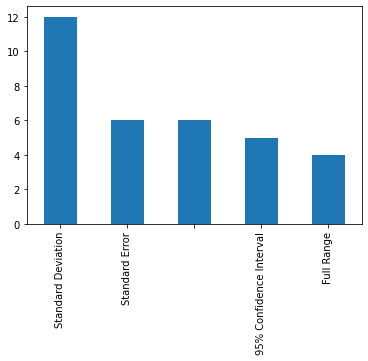

In [52]:
# Let's take a look at the types of mesaurements and see if we can't group them 

placebo_studies['outcome_spread'].value_counts().plot.bar()
# Looks pretty good -> only 3-4 options depending on how you want to process it 

In [53]:
placebo_studies[placebo_studies['outcome_spread'] == 'Standard Error']

,id,name,outcome_groups,drug,conditions,primary_outcomes,verified_date,responsible_party,type,type_description,...,outcome_measure_param,outcomes,outcome_subjects,placebo_group,placebo_scores,control_scores,control_ranges,placebo_ranges,control_no,placebo_no
10,NCT01210079,Hyperalgesia in Methadone-Maintained Patients:...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Opioid-Induced Hyperalgesia],[{'PrimaryOutcomeMeasure': 'Change in Pain Thr...,February 2012,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[-3.49],[2.95],[2.41],[2.85],10,16
18,NCT00619476,Study PXN110748: An Efficacy and Safety Study ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Neuralgia, Postherpetic]",[{'PrimaryOutcomeMeasure': 'Change From Baseli...,January 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[-1.66],"[-2.47, -2.36, -2.72]","[0.204, 0.237, 0.227]",[0.216],87,95
29,NCT01668667,"A Randomized, Double-Blind, Placebo-Controlled...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Restless Legs Syndrome],[{'PrimaryOutcomeMeasure': 'The Change From Ba...,November 2014,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG003,[-9.93],"[-12.50, -12.54, -11.48]","[0.745, 0.764, 0.767]",[0.753],111,117
35,NCT00643760,Study PXN110448: A Dose-response Study of XP13...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Neuropathy, Diabetic]",[{'PrimaryOutcomeMeasure': 'Change From Baseli...,January 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[-2.08],"[-2.43, -2.10, -2.63, -1.65]","[0.274, 0.289, 0.202, 0.266]",[0.196],66,120
38,NCT00748098,"Study RXP110908, a Polysomnography Study of GS...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Restless Legs Syndrome, Restless Legs Syndrom...",[{'PrimaryOutcomeMeasure': 'Adjusted Mean Chan...,January 2013,{'ResponsiblePartyType': 'Sponsor'},Crossover Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[-6.02],[-32.02],[5.020],[4.986],121,123
41,NCT01332318,"A Randomized, Double Blind, Active- and Placeb...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Restless Legs Syndrome],[{'PrimaryOutcomeMeasure': 'Change From Baseli...,June 2011,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[-0.10],"[0.15, 0.15, 0.16]","[0.06, 0.06, 0.06]",[0.06],28,30


In [54]:
# Get the standard deviation for each one of the rows

import math

def get_sd(outcome_spread, ranges, obs):
    if outcome_spread == 'Standard Error':
        return [(math.sqrt(int(obs)) * float(x)) for x in ranges]
    
#     if outcome_spread == '95% Confidence Interval':
#         return [(math.sqrt(int(obs)) * (float(x[1]) - float(x[0])) / 3.92) for x in ranges]
    
    if outcome_spread == 'Standard Deviation':
        return ranges
    
    return -1

placebo_studies['control_sd_ranges'] = placebo_studies.apply(lambda x: get_sd(x.outcome_spread, x.control_ranges, x.control_no), axis=1)
placebo_studies['placebo_sd_ranges'] = placebo_studies.apply(lambda x: get_sd(x.outcome_spread, x.placebo_ranges, x.placebo_no), axis=1)
placebo_studies

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,name,outcome_groups,drug,conditions,primary_outcomes,verified_date,responsible_party,type,type_description,...,outcome_subjects,placebo_group,placebo_scores,control_scores,control_ranges,placebo_ranges,control_no,placebo_no,control_sd_ranges,placebo_sd_ranges
0,NCT02926573,Perioperative Gabapentin Use In Head And Neck ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Head and Neck Cancer, Acute Pain, Postoperati...",[{'PrimaryOutcomeMeasure': 'Change in Daily Na...,July 2018,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[1.59],[1.60],"[(0, 6.11)]","[(0, 5.84)]",44,46,-1,-1
1,NCT00414466,"A Randomized Double Blind, Placebo-controlled,...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Intractable Pain],[{'PrimaryOutcomeMeasure': 'Changes in a Pain ...,August 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[0.48],"[0.40, 0.10, -0.02]","[1.33, 0.99, 1.11]",[1.52],41,43,"[1.33, 0.99, 1.11]",[1.52]
2,NCT00108550,Efficacy of Antidepressants in Chronic Back Pain,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Low Back Pain],[{'PrimaryOutcomeMeasure': 'Transformed Descri...,December 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[0.6683],[0.6988],"[(0.6463, 0.7512)]","[(0.6145, 0.7220)]",55,53,-1,-1
3,NCT02359110,Administration of Pre-Operative Gabapentin to ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'NRS (Numerical Rat...,March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,"[3.4, 5.5, 5.8, 5.1]","[3.5, 5.4, 5.3, 5.7]","[(2.6, 4.5), (4.3, 6.5), (4.2, 6.5), (4.3, 7.2)]","[(2.5, 4.4), (4.3, 6.7), (4.4, 7.1), (3.4, 6.8)]",55,54,-1,-1
5,NCT00726999,Perioperative Use of Gabapentin To Decrease Op...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'Amount of Morphine...,March 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[0.044],[0.064],[0.031],[0.017],32,31,[0.031],[0.017]
7,NCT00793910,Oral Gabapentin Versus Placebo for Treatment o...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],"[{'PrimaryOutcomeMeasure': 'Level of Pain', 'P...",July 2014,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[4.09],[3.85],[2.05],[2.38],41,41,[2.05],[2.38]
8,NCT02703259,Single Dose Preoperative Gabapentin Use in Min...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Pain, Postoperative]",[{'PrimaryOutcomeMeasure': 'Narcotic Use at 24...,May 2020,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[175.0],[158.8],[109.6],[162.5],68,61,[109.6],[162.5]
9,NCT01680549,Pain Control With Total Knee Replacement: Does...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'Patient Pain Score...,January 2017,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,"[33.6, 34.9, 38.0]","[40.0, 46.3, 39.6]","[26.1, 30.5, 18.8]","[23.3, 26.6, 15.9]",20,17,"[26.1, 30.5, 18.8]","[23.3, 26.6, 15.9]"
10,NCT01210079,Hyperalgesia in Methadone-Maintained Patients:...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Opioid-Induced Hyperalgesia],[{'PrimaryOutcomeMeasure': 'Change in Pain Thr...,February 2012,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[-3.49],[2.95],[2.41

In [55]:
# Now let's take a shot at making the effectiveness score - I wonder if we can just take the p-value
# from each of the studies - I can't find the p-value for some but I can use one for others??
# I think getting the range and doing a t-test for each one of the groups - just our own p-value, use the other 
# p-value for sanity check

# For the IQR ranges -> we can estimate the distribution as normal and do SD = IQR/1.35 and run eveything from there

# We also need the number of observations here - so the number of patients for the study 
def get_p_value(placebo_scores, control_scores, control_sd_ranges, placebo_sd_ranges, control_no, placebo_no):
    # What if there is a score imbalance?? can't risk it right now - we need to do strict matching or 1:*
    p_vals = []
    if len(placebo_scores) != len(control_scores) and len(placebo_scores) != 1:
        return [-1]
        
    if len(control_scores) != len(control_sd_ranges) or len(placebo_scores) != len(placebo_sd_ranges):
        return [-2]
    
    
    for i in range(len(control_scores)):
        placebo_index = i if i < len(placebo_scores) else 0        
        p_val = stats.ttest_ind_from_stats(mean1=float(control_scores[i]), std1=float(control_sd_ranges[i]), nobs1=int(control_no),
                                  mean2=float(placebo_scores[placebo_index]), std2=float(placebo_sd_ranges[placebo_index]), nobs2=int(placebo_no)).pvalue
        p_vals.append(p_val)
    
    return p_vals

temp = placebo_studies[placebo_studies['outcome_spread'] == 'Standard Deviation']
temp.apply(lambda x: get_p_value(x.placebo_scores, x.control_scores, x.control_sd_ranges, x.placebo_sd_ranges, x.control_no, x.placebo_no), axis=1)
    

1     [0.7984300486804039, 0.18054242812252252, 0.09...
5                                [0.002451395599569084]
7                                  [0.6260177839799328]
8                                   [0.504229768942563]
9     [0.44038625913776963, 0.23795630669235976, 0.7...
20                                [0.49476163219039715]
27              [0.8607602133461854, 0.292998086240382]
32                                                 [-1]
37                                                 [-1]
39                              [0.0074018084253453026]
74          [0.3211593809628029, 0.0003251805363916385]
76                                                 [-1]
dtype: object

In [81]:
temp.apply(lambda x: print(x.id))

AttributeError: 'Series' object has no attribute 'id'